# CycleGAN Tutorial from Scratch
cyclegan is a pix2pix image generation model that generates images from datasets that do not require pairs.

We will implement this cyclegan directly from the ground up with pytorch, and practice converting monet pictures into pictures and pictures into monet pictures.


# CycleGAN : Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks

[--> Paper](https://openaccess.thecvf.com/content_ICCV_2017/papers/Zhu_Unpaired_Image-To-Image_Translation_ICCV_2017_paper.pdf)

![--> Paper](https://openaccess.thecvf.com/content_ICCV_2017/papers/Zhu_Unpaired_Image-To-Image_Translation_ICCV_2017_paper.pdf)

## Main Reference
1. [PyTorch-GAN | Github/eriklindernoren | Collection of PyTorch implementations of GAN](https://github.com/sw-song/PyTorch-GAN)
2. [CycleGAN | Github/junyanz | Torch implementation for learning an image-to-image translation without input-output pairs](https://github.com/junyanz/CycleGAN)

We will implement the following structure with `PyTorch`

![image](https://miro.medium.com/max/1838/0*S5gn5i6UhfyoRr9S.png)

## Index
```
Step 1. Import Libraries
Step 2. Initial Setting
Step 3. Define Generator
Step 4. Define Discriminator
Step 5. Define Loss Function
Step 6. Initialize Generator and Discriminator
Step 7. GPU Setting
Step 8. Weight Setting
Step 9. Configure Optimizer
Step 10. Learning Rate Scheduler Setting
Step 11. Image Transformation Setting
Step 12. DataLoader Setting
Step 13. Define function to get sample images
Step 14. Training
```
---

### Step 1. Import Libraries

In [137]:
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

### Step 2. Initial Setting

In [138]:
n_cpu = 1 # number of cpu threads to use during batch generation

In [139]:
# data (path)
dataset_name = 'data1'
root = dataset_name

# data (img)
img_height = 256
img_width = 256
channels = 3

# training
epoch = 0 # epoch to start training from
n_epochs = 2 # number of epochs of training
batch_size = 1 # size of the batches
lr = 0.0002 # adam : learning rate
b1 = 0.5 # adam : decay of first order momentum of gradient
b2 = 0.999 # adam : decay of first order momentum of gradient
decay_epoch = 1 # suggested default : 100 (suggested 'n_epochs' is 200)
                 # epoch from which to start lr decay


### Step 3. Define Generator

In [140]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Pads the input tensor using the reflection of the input boundary
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features), 
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_block):
        super(GeneratorResNet, self).__init__()
        
        channels = input_shape[0]
        
        # Initial Convolution Block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True)
        ]
        in_features = out_features
        
        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
        
        # Residual blocks
        for _ in range(num_residual_block):
            model += [ResidualBlock(out_features)]
            
        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2), # --> width*2, heigh*2
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            
        # Output Layer
        model += [nn.ReflectionPad2d(channels),
                  nn.Conv2d(out_features, channels, 7),
                  nn.Tanh()
                 ]
        
        # Unpacking
        self.model = nn.Sequential(*model) 
        
    def forward(self, x):
        return self.model(x)

> TEST CODE : nn.Upsample

In [141]:
tensor = torch.from_numpy(np.random.randn(2,2))

In [142]:
tensor

tensor([[ 1.1613, -0.2073],
        [ 2.8226, -0.4286]], dtype=torch.float64)

In [143]:
tensor = tensor.view(1,1,2,2)
tensor # nn.Upsample get only 3/4/5D tensor

tensor([[[[ 1.1613, -0.2073],
          [ 2.8226, -0.4286]]]], dtype=torch.float64)

In [144]:
test_m = nn.Upsample(scale_factor=2)
test_m(tensor)

tensor([[[[ 1.1613,  1.1613, -0.2073, -0.2073],
          [ 1.1613,  1.1613, -0.2073, -0.2073],
          [ 2.8226,  2.8226, -0.4286, -0.4286],
          [ 2.8226,  2.8226, -0.4286, -0.4286]]]], dtype=torch.float64)

> Read More
- [torch.nn.ReflectionPad2d(padding)](https://pytorch.org/docs/stable/generated/torch.nn.ReflectionPad2d.html)
- [torch.nn.InstanceNorm2d(num_features, ...)](https://pytorch.org/docs/stable/generated/torch.nn.InstanceNorm2d.html)
    - Example : Compare 4dim-Normalization methods,https://wdprogrammer.tistory.com/67

![image](https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Fa23e53c6-47a1-4ae6-96b0-f4836b5d82a8%2FUntitled.png?table=block&id=2e5405fd-24c7-49e1-aa2e-69a80d8b4bf4&width=2800&cache=v2)
- [torch.nn.Upsample(size=None, scale_factor=None, mode='nearest', align_corners=None)](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html)

### Step 4. Define Discriminator

In [145]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        
        channels, height, width = input_shape
        
        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height//2**4, width//2**4)
        
        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128,256),
            *discriminator_block(256,512),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
        
    def forward(self, img):
        return self.model(img)

> TEST CODE : nn.ZeroPad2d

In [146]:
tensor = torch.from_numpy(np.random.randn(2,2))
tensor

tensor([[0.8528, 0.1273],
        [0.5033, 0.7786]], dtype=torch.float64)

In [147]:
test_m = nn.ZeroPad2d((1,0,0,0)) # Padding_left
test_m(tensor)

tensor([[0.0000, 0.8528, 0.1273],
        [0.0000, 0.5033, 0.7786]], dtype=torch.float64)

In [148]:
test_m = nn.ZeroPad2d((0,1,0,0)) # Padding_right
test_m(tensor)

tensor([[0.8528, 0.1273, 0.0000],
        [0.5033, 0.7786, 0.0000]], dtype=torch.float64)

In [149]:
test_m = nn.ZeroPad2d((0,0,1,0)) # Padding_top
test_m(tensor)

tensor([[0.0000, 0.0000],
        [0.8528, 0.1273],
        [0.5033, 0.7786]], dtype=torch.float64)

In [150]:
test_m = nn.ZeroPad2d((0,0,0,1)) # Padding_bottom
test_m(tensor)

tensor([[0.8528, 0.1273],
        [0.5033, 0.7786],
        [0.0000, 0.0000]], dtype=torch.float64)

In [151]:
test_m = nn.ZeroPad2d((1,0,1,0)) # Padding_left and Padding_top
test_m(tensor)

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.8528, 0.1273],
        [0.0000, 0.5033, 0.7786]], dtype=torch.float64)

### Step 5. Define Loss

In [152]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

### Step 6. Initialize Generator and Discriminator

In [153]:
input_shape = (channels, img_height, img_width) # (3,256,256)
n_residual_blocks = 9 # suggested default, number of residual blocks in generator

G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

### Step 7. GPU Setting

In [154]:
cuda = torch.cuda.is_available()

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

### Step 8. Weight Setting

In [155]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) # reset Conv2d's weight(tensor) with Gaussian Distribution
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0) # reset Conv2d's bias(tensor) with Constant(0)
        elif classname.find('BatchNorm2d') != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02) # reset BatchNorm2d's weight(tensor) with Gaussian Distribution
            torch.nn.init.constant_(m.bias.data, 0.0) # reset BatchNorm2d's bias(tensor) with Constant(0)

In [156]:
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

> TEST CODE : `__class__.__name__`


In [157]:
def temp_weights_init_normal(m):
    classname =  m.__class__.__name__
    print(classname)

In [158]:
G_AB.apply(temp_weights_init_normal)

ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
Conv2d
InstanceNorm2d
ReLU
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPa

GeneratorResNet(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        

`torch.nn.init.normal_(tensor, mean=0.0, std=1.0)`
- Fills the input Tensor with values drawn from the normal distribution N(mean, std^2)

In [159]:
temp_w = torch.ones(2,5)
temp_w

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [160]:
nn.init.normal_(temp_w)

tensor([[ 2.0884,  0.0671,  0.9258,  0.5757,  1.6243],
        [ 0.0121, -2.7462, -0.7535, -0.5096, -1.2206]])

`torch.nn.init.constant_(tensor, val)`
- Fills the input Tensor with value `val`


In [161]:
temp_w2 = torch.empty(2,5)
temp_w2

tensor([[1.1683e-05, 8.8282e-43, 8.2134e-01, 8.4477e-01, 1.1082e+00],
        [3.6193e-01, 1.5994e-01, 9.3824e-01, 2.0147e-01, 9.2020e-01]])

In [162]:
nn.init.constant_(temp_w2, 1)

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

> Read More
- [Torch.nn.init](https://pytorch.org/docs/stable/nn.init.html)

### Step 9. Configure Optimizers

In [163]:
import itertools
# lr = 0.0002
# b1 = 0.5
# b2 = 0.999

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1,b2)
)
optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1,b2)
)

### Step 10. Learning Rate Scheduler Setting

In [164]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
        
    def step(self, epoch):
        return 1.0 - max(0, epoch+self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [165]:
# n_epochs = 10
# epoch = 0
# decay_epoch = 5


lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

### Step 11. Image Transformation Setting

In [166]:
from PIL import Image
import torchvision.transforms as transforms

transforms_ = [
    transforms.Resize(int(img_height*1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

### Step 12. DataLoader Setting

In [167]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

In [168]:
import os
import glob

In [169]:
print(root+'/MaskData')

data1/MaskData


In [170]:
len(glob.glob(os.path.join(root+'/MaskData')+'/*.*'))

1023

In [171]:
len(glob.glob(os.path.join(root+'/RandomDataMasked')+'/*.*'))

5126

In [172]:
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.mode = mode
        if self.mode == 'train':
            self.files_A = sorted(glob.glob(os.path.join(root+'/MaskData')+'/*.*')[:250])
            self.files_B = sorted(glob.glob(os.path.join(root+'/RandomDataMasked')+'/*.*')[:250])
        elif self.mode == 'test':
            self.files_A = sorted(glob.glob(os.path.join(root+'/MaskData')+'/*.*')[250:])
            self.files_B = sorted(glob.glob(os.path.join(root+'/RandomDataMasked')+'/*.*')[250:301])

    def  __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        
        if self.unaligned:
            image_B = Image.open(self.files_B[np.random.randint(0, len(self.files_B)-1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])
        if image_A.mode != 'RGB':
            image_A = to_rgb(image_A)
        if image_B.mode != 'RGB':
            image_B = to_rgb(image_B)
            
        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {'A':item_A, 'B':item_B}
    
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))
            

In [173]:
dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True),
    batch_size=1, # 1
    shuffle=True
    
)

val_dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True, mode='test'),
    batch_size=5,
    shuffle=True
)

### Step 13. Define function to get sample images

In [174]:
import matplotlib.pyplot as plt

In [175]:
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [176]:
def sample_images():
    """show a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = imgs['A'].type(Tensor) # A : monet
    fake_B = G_AB(real_A).detach()
    real_B = imgs['B'].type(Tensor) # B : photo
    fake_A = G_BA(real_B).detach()
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    # Arange images along y-axis    
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    plt.imshow(image_grid.cpu().permute(1,2,0))
    plt.title('Real A vs Fake B | Real B vs Fake A')
    plt.axis('off')
    plt.show()

> TEST CODE : show image data

In [177]:
temp_imgs = next(iter(val_dataloader))

In [178]:
G_AB.eval() # test mode 
G_BA.eval() # test mode
print(temp_imgs['A'].shape)
print(temp_imgs['B'].shape)


torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])


In [179]:
temp_real_A = temp_imgs['A'].type(Tensor) # A : monet
temp_fake_B = G_AB(temp_real_A).detach()
temp_real_B = temp_imgs['B'].type(Tensor) # B : photo
temp_fake_A = G_BA(temp_real_B).detach()

In [180]:
print(temp_real_A.shape)
print(temp_fake_B.shape)
print(temp_real_B.shape)
print(temp_fake_A.shape)

torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])


In [181]:
temp_real_A = make_grid(temp_real_A, nrow=5, normalize=True)
temp_real_B = make_grid(temp_real_B, nrow=5, normalize=True)
temp_fake_A = make_grid(temp_fake_A, nrow=5, normalize=True)
temp_fake_B = make_grid(temp_fake_B, nrow=5, normalize=True)

In [182]:
type(temp_real_A)

torch.Tensor

(-0.5, 1291.5, 259.5, -0.5)

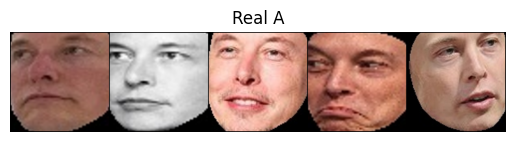

In [183]:
plt.imshow(temp_real_A.cpu().permute(1,2,0))
plt.title('Real A')
plt.axis('off')

In [184]:
print(temp_real_A.shape)
print(temp_fake_B.shape)
print(temp_real_B.shape)
print(temp_fake_A.shape)

torch.Size([3, 260, 1292])
torch.Size([3, 260, 1292])
torch.Size([3, 260, 1292])
torch.Size([3, 260, 1292])


In [185]:
temp_image_grid = torch.cat((temp_real_A, temp_fake_A, temp_real_B, temp_fake_B), 1)
print(temp_image_grid.shape)

torch.Size([3, 1040, 1292])


In [186]:
temp_image_grid.cpu().permute(1,2,0).shape

torch.Size([1040, 1292, 3])

(-0.5, 1291.5, 1039.5, -0.5)

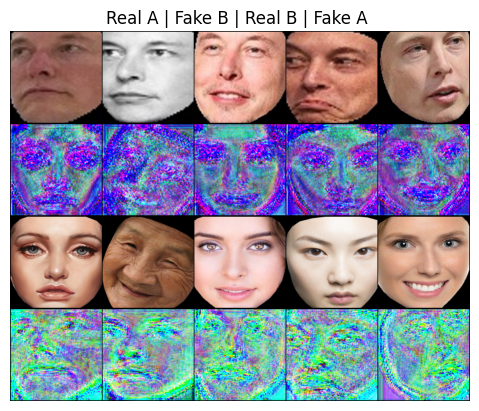

In [187]:
plt.imshow(temp_image_grid.cpu().permute(1,2,0))
plt.title('Real A | Fake B | Real B | Fake A ')
plt.axis('off')

### Step 14. Training

In [188]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

In [189]:
from tqdm import tqdm
torch.cuda.empty_cache()
for epoch in range(epoch, n_epochs):
    torch.cuda.empty_cache()
    for i, batch in enumerate(tqdm(dataloader)):
        torch.cuda.empty_cache()
        # Set model input
        real_A = batch['A'].type(Tensor)
        real_B = batch['B'].type(Tensor)
        
        # Adversarial ground truths
        valid = Tensor(np.ones((real_A.size(0), *D_A.output_shape)))
        fake = Tensor(np.zeros((real_A.size(0), *D_A.output_shape)))
        
        # Train Generators
        G_AB.train()
        G_BA.train()
        optimizer_G.zero_grad()
        
        # Identity Loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        
        # GAN Loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        # Cycle Loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        
        # Total Loss
        loss_G = loss_GAN + (10.0 * loss_cycle) + (5.0 * loss_identity)
        
        loss_G.backward()
        optimizer_G.step()
        
        # Train Discriminator A
        optimizer_D_A.zero_grad()
        loss_real = criterion_GAN(D_A(real_A), valid)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_real + loss_fake) / 2
        loss_D_A.backward()
        optimizer_D_A.step()

        # Train Discriminator B
        optimizer_D_B.zero_grad()
        loss_real = criterion_GAN(D_B(real_B), valid)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_real + loss_fake) / 2
        loss_D_B.backward()
        optimizer_D_B.step()
        torch.cuda.empty_cache()
        # Show Progress
        # if (i+1) % 50 == 0:
        #     sample_images()
        print('[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]')
            # % (epoch+1, n_epochs, i+1, len(dataloader), loss_D_A.item() + loss_D_B.item(), loss_G.item(), loss_GAN.item(), loss_cycle.item(), loss_identity.item()))


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<02:20,  1.77it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  1%|          | 2/250 [00:01<02:30,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  1%|          | 3/250 [00:01<02:31,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  2%|▏         | 4/250 [00:02<02:27,  1.67it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  2%|▏         | 5/250 [00:02<02:25,  1.69it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  2%|▏         | 6/250 [00:03<02:46,  1.46it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  3%|▎         | 7/250 [00:04<02:37,  1.54it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  3%|▎         | 8/250 [00:04<02:30,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  4%|▎         | 9/250 [00:05<02:31,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  4%|▍         | 10/250 [00:06<02:47,  1.43it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  4%|▍         | 11/250 [00:07<02:39,  1.50it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  5%|▍         | 12/250 [00:07<02:32,  1.56it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  5%|▌         | 13/250 [00:08<02:29,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  6%|▌         | 14/250 [00:08<02:26,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  6%|▌         | 15/250 [00:09<02:25,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  6%|▋         | 16/250 [00:10<02:23,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  7%|▋         | 17/250 [00:10<02:20,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  7%|▋         | 18/250 [00:11<02:34,  1.50it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  8%|▊         | 19/250 [00:12<02:27,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  8%|▊         | 20/250 [00:12<02:23,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  8%|▊         | 21/250 [00:13<02:19,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  9%|▉         | 22/250 [00:13<02:18,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  9%|▉         | 23/250 [00:14<02:20,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 10%|▉         | 24/250 [00:15<02:16,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 10%|█         | 25/250 [00:15<02:14,  1.68it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 10%|█         | 26/250 [00:16<02:27,  1.52it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 11%|█         | 27/250 [00:16<02:20,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 11%|█         | 28/250 [00:17<02:15,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 12%|█▏        | 29/250 [00:18<02:11,  1.68it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 12%|█▏        | 30/250 [00:18<02:10,  1.68it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 12%|█▏        | 31/250 [00:19<02:09,  1.69it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 13%|█▎        | 32/250 [00:19<02:09,  1.68it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 13%|█▎        | 33/250 [00:20<02:09,  1.67it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 14%|█▎        | 34/250 [00:21<02:08,  1.69it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 14%|█▍        | 35/250 [00:21<02:19,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 14%|█▍        | 36/250 [00:22<02:15,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 15%|█▍        | 37/250 [00:23<02:11,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 15%|█▌        | 38/250 [00:23<02:08,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 16%|█▌        | 39/250 [00:24<02:08,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 16%|█▌        | 40/250 [00:24<02:06,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 16%|█▋        | 41/250 [00:25<02:06,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 17%|█▋        | 42/250 [00:25<02:04,  1.67it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 17%|█▋        | 43/250 [00:26<02:18,  1.50it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 18%|█▊        | 44/250 [00:27<02:09,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 18%|█▊        | 45/250 [00:27<02:05,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 18%|█▊        | 46/250 [00:28<02:02,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 19%|█▉        | 47/250 [00:29<02:01,  1.67it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 19%|█▉        | 48/250 [00:29<01:58,  1.70it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 20%|█▉        | 49/250 [00:30<01:55,  1.74it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 20%|██        | 50/250 [00:30<01:55,  1.73it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 20%|██        | 51/250 [00:31<02:08,  1.54it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 21%|██        | 52/250 [00:32<02:02,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 21%|██        | 53/250 [00:32<01:58,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 22%|██▏       | 54/250 [00:33<01:56,  1.68it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 22%|██▏       | 55/250 [00:33<01:55,  1.68it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 22%|██▏       | 56/250 [00:34<01:53,  1.70it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 23%|██▎       | 57/250 [00:35<01:53,  1.70it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 23%|██▎       | 58/250 [00:35<01:53,  1.69it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 24%|██▎       | 59/250 [00:36<01:54,  1.67it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 24%|██▍       | 60/250 [00:36<01:52,  1.68it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 24%|██▍       | 61/250 [00:37<01:52,  1.68it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 25%|██▍       | 62/250 [00:38<01:50,  1.70it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 25%|██▌       | 63/250 [00:38<01:48,  1.72it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 26%|██▌       | 64/250 [00:39<01:59,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 26%|██▌       | 65/250 [00:39<01:54,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 26%|██▋       | 66/250 [00:40<01:49,  1.67it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 27%|██▋       | 67/250 [00:41<01:48,  1.69it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 27%|██▋       | 68/250 [00:41<01:46,  1.70it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 28%|██▊       | 69/250 [00:42<01:45,  1.71it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 28%|██▊       | 70/250 [00:42<01:44,  1.72it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 28%|██▊       | 71/250 [00:43<01:45,  1.69it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 29%|██▉       | 72/250 [00:43<01:43,  1.71it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 29%|██▉       | 73/250 [00:44<01:42,  1.73it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 30%|██▉       | 74/250 [00:45<01:42,  1.72it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 30%|███       | 75/250 [00:45<01:41,  1.72it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 30%|███       | 76/250 [00:46<01:40,  1.74it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 31%|███       | 77/250 [00:46<01:42,  1.68it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 31%|███       | 78/250 [00:47<01:41,  1.69it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 32%|███▏      | 79/250 [00:48<01:40,  1.70it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 32%|███▏      | 80/250 [00:48<01:49,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 32%|███▏      | 81/250 [00:49<01:44,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 33%|███▎      | 82/250 [00:49<01:40,  1.67it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 33%|███▎      | 83/250 [00:50<01:39,  1.67it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 34%|███▎      | 84/250 [00:51<01:38,  1.69it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 34%|███▍      | 85/250 [00:51<01:38,  1.68it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 34%|███▍      | 86/250 [00:52<01:38,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 35%|███▍      | 87/250 [00:52<01:37,  1.67it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 35%|███▌      | 88/250 [00:53<01:37,  1.67it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 36%|███▌      | 89/250 [00:54<01:45,  1.52it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 36%|███▌      | 90/250 [00:54<01:39,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 36%|███▋      | 91/250 [00:55<01:38,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 37%|███▋      | 92/250 [00:56<01:35,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 37%|███▋      | 93/250 [00:56<01:35,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 38%|███▊      | 94/250 [00:57<01:34,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 38%|███▊      | 95/250 [00:57<01:34,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 38%|███▊      | 96/250 [00:58<01:33,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 39%|███▉      | 97/250 [00:59<01:32,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 39%|███▉      | 98/250 [00:59<01:30,  1.68it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 40%|███▉      | 99/250 [01:00<01:29,  1.68it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 40%|████      | 100/250 [01:00<01:28,  1.69it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 40%|████      | 101/250 [01:01<01:28,  1.69it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 41%|████      | 102/250 [01:02<01:27,  1.70it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 41%|████      | 103/250 [01:02<01:27,  1.68it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 42%|████▏     | 104/250 [01:03<01:28,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 42%|████▏     | 105/250 [01:03<01:27,  1.67it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 42%|████▏     | 106/250 [01:04<01:35,  1.52it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 43%|████▎     | 107/250 [01:05<01:32,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 43%|████▎     | 108/250 [01:05<01:29,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 44%|████▎     | 109/250 [01:06<01:28,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 44%|████▍     | 110/250 [01:07<01:27,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 44%|████▍     | 111/250 [01:07<01:26,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 45%|████▍     | 112/250 [01:08<01:26,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 45%|████▌     | 113/250 [01:08<01:26,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 46%|████▌     | 114/250 [01:09<01:24,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 46%|████▌     | 115/250 [01:10<01:22,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 46%|████▋     | 116/250 [01:10<01:21,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 47%|████▋     | 117/250 [01:11<01:19,  1.67it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 47%|████▋     | 118/250 [01:11<01:18,  1.69it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 48%|████▊     | 119/250 [01:12<01:26,  1.52it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 48%|████▊     | 120/250 [01:13<01:22,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 48%|████▊     | 121/250 [01:13<01:20,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 49%|████▉     | 122/250 [01:14<01:19,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 49%|████▉     | 123/250 [01:15<01:18,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 50%|████▉     | 124/250 [01:15<01:16,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 50%|█████     | 125/250 [01:16<01:15,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 50%|█████     | 126/250 [01:16<01:15,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 51%|█████     | 127/250 [01:17<01:14,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 51%|█████     | 128/250 [01:18<01:14,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 52%|█████▏    | 129/250 [01:18<01:20,  1.50it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 52%|█████▏    | 130/250 [01:19<01:17,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 52%|█████▏    | 131/250 [01:20<01:14,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 53%|█████▎    | 132/250 [01:20<01:13,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 53%|█████▎    | 133/250 [01:21<01:11,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 54%|█████▎    | 134/250 [01:21<01:10,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 54%|█████▍    | 135/250 [01:22<01:09,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 54%|█████▍    | 136/250 [01:23<01:08,  1.67it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 55%|█████▍    | 137/250 [01:23<01:07,  1.67it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 55%|█████▌    | 138/250 [01:24<01:06,  1.68it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 56%|█████▌    | 139/250 [01:24<01:06,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 56%|█████▌    | 140/250 [01:25<01:05,  1.67it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 56%|█████▋    | 141/250 [01:26<01:11,  1.53it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 57%|█████▋    | 142/250 [01:26<01:08,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 57%|█████▋    | 143/250 [01:27<01:06,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 58%|█████▊    | 144/250 [01:28<01:04,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 58%|█████▊    | 145/250 [01:28<01:03,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 58%|█████▊    | 146/250 [01:29<01:04,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 59%|█████▉    | 147/250 [01:29<01:04,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 59%|█████▉    | 148/250 [01:30<01:03,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 60%|█████▉    | 149/250 [01:31<01:01,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 60%|██████    | 150/250 [01:31<01:00,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 60%|██████    | 151/250 [01:32<00:59,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 61%|██████    | 152/250 [01:33<01:04,  1.52it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 61%|██████    | 153/250 [01:33<01:02,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 62%|██████▏   | 154/250 [01:34<01:01,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 62%|██████▏   | 155/250 [01:35<01:01,  1.56it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 62%|██████▏   | 156/250 [01:35<01:00,  1.56it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 63%|██████▎   | 157/250 [01:36<00:58,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 63%|██████▎   | 158/250 [01:36<00:57,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 64%|██████▎   | 159/250 [01:37<01:02,  1.46it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 64%|██████▍   | 160/250 [01:38<00:58,  1.53it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 64%|██████▍   | 161/250 [01:38<00:56,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 65%|██████▍   | 162/250 [01:39<00:55,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 65%|██████▌   | 163/250 [01:40<00:55,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 66%|██████▌   | 164/250 [01:40<00:53,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 66%|██████▌   | 165/250 [01:41<00:53,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 66%|██████▋   | 166/250 [01:42<00:57,  1.45it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 67%|██████▋   | 167/250 [01:42<00:54,  1.51it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 67%|██████▋   | 168/250 [01:43<00:52,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 68%|██████▊   | 169/250 [01:44<00:51,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 68%|██████▊   | 170/250 [01:44<00:49,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 68%|██████▊   | 171/250 [01:45<00:48,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 69%|██████▉   | 172/250 [01:45<00:48,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 69%|██████▉   | 173/250 [01:46<00:48,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 70%|██████▉   | 174/250 [01:47<00:47,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 70%|███████   | 175/250 [01:47<00:46,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 70%|███████   | 176/250 [01:48<00:45,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 71%|███████   | 177/250 [01:49<00:48,  1.50it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 71%|███████   | 178/250 [01:49<00:46,  1.56it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 72%|███████▏  | 179/250 [01:50<00:44,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 72%|███████▏  | 180/250 [01:50<00:43,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 72%|███████▏  | 181/250 [01:51<00:42,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 73%|███████▎  | 182/250 [01:52<00:41,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 73%|███████▎  | 183/250 [01:52<00:41,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 74%|███████▎  | 184/250 [01:53<00:40,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 74%|███████▍  | 185/250 [01:53<00:40,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 74%|███████▍  | 186/250 [01:54<00:39,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 75%|███████▍  | 187/250 [01:55<00:42,  1.49it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 75%|███████▌  | 188/250 [01:55<00:40,  1.54it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 76%|███████▌  | 189/250 [01:56<00:39,  1.56it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 76%|███████▌  | 190/250 [01:57<00:37,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 76%|███████▋  | 191/250 [01:57<00:36,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 77%|███████▋  | 192/250 [01:58<00:36,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 77%|███████▋  | 193/250 [01:59<00:35,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 78%|███████▊  | 194/250 [01:59<00:34,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 78%|███████▊  | 195/250 [02:00<00:34,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 78%|███████▊  | 196/250 [02:00<00:33,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 79%|███████▉  | 197/250 [02:01<00:36,  1.47it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 79%|███████▉  | 198/250 [02:02<00:34,  1.52it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 80%|███████▉  | 199/250 [02:02<00:33,  1.54it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 80%|████████  | 200/250 [02:03<00:31,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 80%|████████  | 201/250 [02:04<00:30,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 81%|████████  | 202/250 [02:04<00:29,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 81%|████████  | 203/250 [02:05<00:32,  1.46it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 82%|████████▏ | 204/250 [02:06<00:30,  1.52it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 82%|████████▏ | 205/250 [02:06<00:29,  1.54it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 82%|████████▏ | 206/250 [02:07<00:28,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 83%|████████▎ | 207/250 [02:08<00:27,  1.56it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 83%|████████▎ | 208/250 [02:08<00:26,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 84%|████████▎ | 209/250 [02:09<00:27,  1.48it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 84%|████████▍ | 210/250 [02:10<00:25,  1.54it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 84%|████████▍ | 211/250 [02:10<00:25,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 85%|████████▍ | 212/250 [02:11<00:23,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 85%|████████▌ | 213/250 [02:11<00:22,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 86%|████████▌ | 214/250 [02:12<00:22,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 86%|████████▌ | 215/250 [02:13<00:21,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 86%|████████▋ | 216/250 [02:13<00:20,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 87%|████████▋ | 217/250 [02:14<00:20,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 87%|████████▋ | 218/250 [02:15<00:19,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 88%|████████▊ | 219/250 [02:15<00:19,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 88%|████████▊ | 220/250 [02:16<00:20,  1.48it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 88%|████████▊ | 221/250 [02:17<00:18,  1.53it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 89%|████████▉ | 222/250 [02:17<00:18,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 89%|████████▉ | 223/250 [02:18<00:17,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 90%|████████▉ | 224/250 [02:18<00:16,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 90%|█████████ | 225/250 [02:19<00:15,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 90%|█████████ | 226/250 [02:20<00:14,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 91%|█████████ | 227/250 [02:20<00:14,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 91%|█████████ | 228/250 [02:21<00:15,  1.44it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 92%|█████████▏| 229/250 [02:22<00:13,  1.51it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 92%|█████████▏| 230/250 [02:22<00:13,  1.54it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 92%|█████████▏| 231/250 [02:23<00:12,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 93%|█████████▎| 232/250 [02:23<00:11,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 93%|█████████▎| 233/250 [02:24<00:10,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 94%|█████████▎| 234/250 [02:25<00:09,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 94%|█████████▍| 235/250 [02:25<00:09,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 94%|█████████▍| 236/250 [02:26<00:08,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 95%|█████████▍| 237/250 [02:27<00:08,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 95%|█████████▌| 238/250 [02:27<00:07,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 96%|█████████▌| 239/250 [02:28<00:07,  1.49it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 96%|█████████▌| 240/250 [02:29<00:06,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 96%|█████████▋| 241/250 [02:29<00:05,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 97%|█████████▋| 242/250 [02:30<00:05,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 97%|█████████▋| 243/250 [02:30<00:04,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 98%|█████████▊| 244/250 [02:31<00:03,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 98%|█████████▊| 245/250 [02:32<00:03,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 98%|█████████▊| 246/250 [02:32<00:02,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 99%|█████████▉| 247/250 [02:33<00:01,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 99%|█████████▉| 248/250 [02:33<00:01,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


100%|█████████▉| 249/250 [02:34<00:00,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


100%|██████████| 250/250 [02:35<00:00,  1.61it/s]


[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  0%|          | 1/250 [00:00<02:28,  1.68it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  1%|          | 2/250 [00:01<02:57,  1.40it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  1%|          | 3/250 [00:02<02:48,  1.46it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  2%|▏         | 4/250 [00:02<02:39,  1.54it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  2%|▏         | 5/250 [00:03<02:36,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  2%|▏         | 6/250 [00:03<02:35,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  3%|▎         | 7/250 [00:04<02:32,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  3%|▎         | 8/250 [00:05<02:29,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  4%|▎         | 9/250 [00:05<02:31,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  4%|▍         | 10/250 [00:06<02:42,  1.48it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  4%|▍         | 11/250 [00:07<02:36,  1.52it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  5%|▍         | 12/250 [00:07<02:33,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  5%|▌         | 13/250 [00:08<02:29,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  6%|▌         | 14/250 [00:08<02:26,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  6%|▌         | 15/250 [00:09<02:26,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  6%|▋         | 16/250 [00:10<02:24,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  7%|▋         | 17/250 [00:10<02:22,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  7%|▋         | 18/250 [00:11<02:21,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  8%|▊         | 19/250 [00:11<02:20,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  8%|▊         | 20/250 [00:12<02:19,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  8%|▊         | 21/250 [00:13<02:21,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  9%|▉         | 22/250 [00:13<02:18,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


  9%|▉         | 23/250 [00:14<02:17,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 10%|▉         | 24/250 [00:15<02:15,  1.67it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 10%|█         | 25/250 [00:15<02:27,  1.52it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 10%|█         | 26/250 [00:16<02:21,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 11%|█         | 27/250 [00:16<02:17,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 11%|█         | 28/250 [00:17<02:18,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 12%|█▏        | 29/250 [00:18<02:17,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 12%|█▏        | 30/250 [00:18<02:17,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 12%|█▏        | 31/250 [00:19<02:27,  1.48it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 13%|█▎        | 32/250 [00:20<02:20,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 13%|█▎        | 33/250 [00:20<02:18,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 14%|█▎        | 34/250 [00:21<02:13,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 14%|█▍        | 35/250 [00:22<02:12,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 14%|█▍        | 36/250 [00:22<02:13,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 15%|█▍        | 37/250 [00:23<02:12,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 15%|█▌        | 38/250 [00:23<02:10,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 16%|█▌        | 39/250 [00:24<02:08,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 16%|█▌        | 40/250 [00:25<02:07,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 16%|█▋        | 41/250 [00:25<02:19,  1.49it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 17%|█▋        | 42/250 [00:26<02:13,  1.56it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 17%|█▋        | 43/250 [00:27<02:08,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 18%|█▊        | 44/250 [00:27<02:07,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 18%|█▊        | 45/250 [00:28<02:05,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 18%|█▊        | 46/250 [00:28<02:05,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 19%|█▉        | 47/250 [00:29<02:04,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 19%|█▉        | 48/250 [00:30<02:02,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 20%|█▉        | 49/250 [00:30<02:03,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 20%|██        | 50/250 [00:31<02:02,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 20%|██        | 51/250 [00:31<02:03,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 21%|██        | 52/250 [00:32<02:01,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 21%|██        | 53/250 [00:33<02:15,  1.45it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 22%|██▏       | 54/250 [00:34<02:08,  1.52it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 22%|██▏       | 55/250 [00:34<02:04,  1.56it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 22%|██▏       | 56/250 [00:35<01:59,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 23%|██▎       | 57/250 [00:35<01:57,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 23%|██▎       | 58/250 [00:36<01:57,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 24%|██▎       | 59/250 [00:36<01:56,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 24%|██▍       | 60/250 [00:37<01:55,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 24%|██▍       | 61/250 [00:38<01:58,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 25%|██▍       | 62/250 [00:39<02:06,  1.48it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 25%|██▌       | 63/250 [00:39<02:01,  1.54it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 26%|██▌       | 64/250 [00:40<01:57,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 26%|██▌       | 65/250 [00:40<01:54,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 26%|██▋       | 66/250 [00:41<01:54,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 27%|██▋       | 67/250 [00:42<01:53,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 27%|██▋       | 68/250 [00:42<01:52,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 28%|██▊       | 69/250 [00:43<01:56,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 28%|██▊       | 70/250 [00:43<01:53,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 28%|██▊       | 71/250 [00:44<02:01,  1.47it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 29%|██▉       | 72/250 [00:45<01:57,  1.52it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 29%|██▉       | 73/250 [00:45<01:52,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 30%|██▉       | 74/250 [00:46<01:50,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 30%|███       | 75/250 [00:47<01:50,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 30%|███       | 76/250 [00:47<01:49,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 31%|███       | 77/250 [00:48<01:48,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 31%|███       | 78/250 [00:49<01:45,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 32%|███▏      | 79/250 [00:49<01:45,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 32%|███▏      | 80/250 [00:50<01:44,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 32%|███▏      | 81/250 [00:51<01:53,  1.48it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 33%|███▎      | 82/250 [00:51<01:49,  1.53it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 33%|███▎      | 83/250 [00:52<01:45,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 34%|███▎      | 84/250 [00:52<01:44,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 34%|███▍      | 85/250 [00:53<01:44,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 34%|███▍      | 86/250 [00:54<01:41,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 35%|███▍      | 87/250 [00:54<01:39,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 35%|███▌      | 88/250 [00:55<01:38,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 36%|███▌      | 89/250 [00:55<01:36,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 36%|███▌      | 90/250 [00:56<01:36,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 36%|███▋      | 91/250 [00:57<01:44,  1.52it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 37%|███▋      | 92/250 [00:57<01:39,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 37%|███▋      | 93/250 [00:58<01:37,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 38%|███▊      | 94/250 [00:59<01:35,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 38%|███▊      | 95/250 [00:59<01:33,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 38%|███▊      | 96/250 [01:00<01:33,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 39%|███▉      | 97/250 [01:00<01:32,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 39%|███▉      | 98/250 [01:01<01:32,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 40%|███▉      | 99/250 [01:02<01:31,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 40%|████      | 100/250 [01:02<01:29,  1.68it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 40%|████      | 101/250 [01:03<01:29,  1.67it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 41%|████      | 102/250 [01:04<01:38,  1.50it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 41%|████      | 103/250 [01:04<01:35,  1.54it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 42%|████▏     | 104/250 [01:05<01:31,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 42%|████▏     | 105/250 [01:05<01:29,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 42%|████▏     | 106/250 [01:06<01:28,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 43%|████▎     | 107/250 [01:07<01:27,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 43%|████▎     | 108/250 [01:07<01:26,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 44%|████▎     | 109/250 [01:08<01:27,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 44%|████▍     | 110/250 [01:09<01:34,  1.48it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 44%|████▍     | 111/250 [01:09<01:33,  1.49it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 45%|████▍     | 112/250 [01:10<01:29,  1.54it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 45%|████▌     | 113/250 [01:10<01:26,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 46%|████▌     | 114/250 [01:11<01:24,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 46%|████▌     | 115/250 [01:12<01:31,  1.48it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 46%|████▋     | 116/250 [01:12<01:26,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 47%|████▋     | 117/250 [01:13<01:22,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 47%|████▋     | 118/250 [01:14<01:21,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 48%|████▊     | 119/250 [01:14<01:20,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 48%|████▊     | 120/250 [01:15<01:19,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 48%|████▊     | 121/250 [01:15<01:19,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 49%|████▉     | 122/250 [01:16<01:17,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 49%|████▉     | 123/250 [01:17<01:23,  1.52it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 50%|████▉     | 124/250 [01:17<01:20,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 50%|█████     | 125/250 [01:18<01:16,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 50%|█████     | 126/250 [01:19<01:14,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 51%|█████     | 127/250 [01:19<01:15,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 51%|█████     | 128/250 [01:20<01:13,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 52%|█████▏    | 129/250 [01:20<01:12,  1.68it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 52%|█████▏    | 130/250 [01:21<01:11,  1.68it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 52%|█████▏    | 131/250 [01:22<01:11,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 53%|█████▎    | 132/250 [01:22<01:14,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 53%|█████▎    | 133/250 [01:23<01:13,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 54%|█████▎    | 134/250 [01:23<01:11,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 54%|█████▍    | 135/250 [01:24<01:19,  1.44it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 54%|█████▍    | 136/250 [01:25<01:14,  1.52it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 55%|█████▍    | 137/250 [01:25<01:12,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 55%|█████▌    | 138/250 [01:26<01:09,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 56%|█████▌    | 139/250 [01:27<01:08,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 56%|█████▌    | 140/250 [01:27<01:07,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 56%|█████▋    | 141/250 [01:28<01:06,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 57%|█████▋    | 142/250 [01:28<01:05,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 57%|█████▋    | 143/250 [01:29<01:05,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 58%|█████▊    | 144/250 [01:30<01:04,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 58%|█████▊    | 145/250 [01:31<01:15,  1.39it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 58%|█████▊    | 146/250 [01:31<01:14,  1.40it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 59%|█████▉    | 147/250 [01:32<01:12,  1.43it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 59%|█████▉    | 148/250 [01:33<01:08,  1.49it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 60%|█████▉    | 149/250 [01:33<01:05,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 60%|██████    | 150/250 [01:34<01:03,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 60%|██████    | 151/250 [01:35<01:13,  1.34it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 61%|██████    | 152/250 [01:35<01:08,  1.43it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 61%|██████    | 153/250 [01:36<01:04,  1.49it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 62%|██████▏   | 154/250 [01:37<01:01,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 62%|██████▏   | 155/250 [01:37<01:00,  1.56it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 62%|██████▏   | 156/250 [01:38<00:59,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 63%|██████▎   | 157/250 [01:39<00:59,  1.56it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 63%|██████▎   | 158/250 [01:39<00:57,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 64%|██████▎   | 159/250 [01:40<01:05,  1.40it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 64%|██████▍   | 160/250 [01:41<01:01,  1.47it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 64%|██████▍   | 161/250 [01:41<00:58,  1.52it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 65%|██████▍   | 162/250 [01:42<00:56,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 65%|██████▌   | 163/250 [01:42<00:55,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 66%|██████▌   | 164/250 [01:43<00:54,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 66%|██████▌   | 165/250 [01:44<00:53,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 66%|██████▋   | 166/250 [01:44<00:52,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 67%|██████▋   | 167/250 [01:45<00:52,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 67%|██████▋   | 168/250 [01:46<00:51,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 68%|██████▊   | 169/250 [01:46<00:51,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 68%|██████▊   | 170/250 [01:47<00:56,  1.42it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 68%|██████▊   | 171/250 [01:48<00:53,  1.49it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 69%|██████▉   | 172/250 [01:48<00:51,  1.52it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 69%|██████▉   | 173/250 [01:49<00:48,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 70%|██████▉   | 174/250 [01:50<00:47,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 70%|███████   | 175/250 [01:50<00:47,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 70%|███████   | 176/250 [01:51<00:45,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 71%|███████   | 177/250 [01:51<00:45,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 71%|███████   | 178/250 [01:52<00:43,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 72%|███████▏  | 179/250 [01:53<00:43,  1.65it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 72%|███████▏  | 180/250 [01:53<00:46,  1.51it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 72%|███████▏  | 181/250 [01:54<00:44,  1.56it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 73%|███████▎  | 182/250 [01:55<00:42,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 73%|███████▎  | 183/250 [01:55<00:41,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 74%|███████▎  | 184/250 [01:56<00:40,  1.62it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 74%|███████▍  | 185/250 [01:56<00:41,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 74%|███████▍  | 186/250 [01:57<00:40,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 75%|███████▍  | 187/250 [01:58<00:43,  1.44it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 75%|███████▌  | 188/250 [01:58<00:40,  1.52it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 76%|███████▌  | 189/250 [01:59<00:39,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 76%|███████▌  | 190/250 [02:00<00:38,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 76%|███████▋  | 191/250 [02:00<00:38,  1.54it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 77%|███████▋  | 192/250 [02:01<00:37,  1.54it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 77%|███████▋  | 193/250 [02:02<00:36,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 78%|███████▊  | 194/250 [02:02<00:35,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 78%|███████▊  | 195/250 [02:03<00:34,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 78%|███████▊  | 196/250 [02:04<00:33,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 79%|███████▉  | 197/250 [02:04<00:36,  1.47it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 79%|███████▉  | 198/250 [02:05<00:33,  1.54it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 80%|███████▉  | 199/250 [02:06<00:32,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 80%|████████  | 200/250 [02:06<00:31,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 80%|████████  | 201/250 [02:07<00:30,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 81%|████████  | 202/250 [02:07<00:29,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 81%|████████  | 203/250 [02:08<00:28,  1.63it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 82%|████████▏ | 204/250 [02:09<00:27,  1.67it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 82%|████████▏ | 205/250 [02:09<00:27,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 82%|████████▏ | 206/250 [02:10<00:26,  1.67it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 83%|████████▎ | 207/250 [02:10<00:25,  1.68it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 83%|████████▎ | 208/250 [02:11<00:25,  1.66it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 84%|████████▎ | 209/250 [02:12<00:25,  1.64it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 84%|████████▍ | 210/250 [02:12<00:25,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 84%|████████▍ | 211/250 [02:13<00:27,  1.44it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 85%|████████▍ | 212/250 [02:14<00:25,  1.48it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 85%|████████▌ | 213/250 [02:14<00:24,  1.53it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 86%|████████▌ | 214/250 [02:15<00:22,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 86%|████████▌ | 215/250 [02:16<00:22,  1.57it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 86%|████████▋ | 216/250 [02:16<00:23,  1.45it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 87%|████████▋ | 217/250 [02:17<00:22,  1.47it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 87%|████████▋ | 218/250 [02:18<00:20,  1.53it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 88%|████████▊ | 219/250 [02:18<00:19,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 88%|████████▊ | 220/250 [02:19<00:18,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 88%|████████▊ | 221/250 [02:19<00:18,  1.61it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 89%|████████▉ | 222/250 [02:20<00:18,  1.50it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 89%|████████▉ | 223/250 [02:21<00:18,  1.49it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 90%|████████▉ | 224/250 [02:22<00:17,  1.47it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 90%|█████████ | 225/250 [02:22<00:16,  1.49it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 90%|█████████ | 226/250 [02:24<00:23,  1.00it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 91%|█████████ | 227/250 [02:25<00:22,  1.04it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 91%|█████████ | 228/250 [02:26<00:19,  1.12it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 92%|█████████▏| 229/250 [02:26<00:17,  1.22it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 92%|█████████▏| 230/250 [02:27<00:15,  1.27it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 92%|█████████▏| 231/250 [02:28<00:14,  1.34it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 93%|█████████▎| 232/250 [02:28<00:13,  1.37it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 93%|█████████▎| 233/250 [02:29<00:13,  1.23it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 94%|█████████▎| 234/250 [02:30<00:11,  1.34it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 94%|█████████▍| 235/250 [02:30<00:10,  1.44it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 94%|█████████▍| 236/250 [02:31<00:09,  1.52it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 95%|█████████▍| 237/250 [02:32<00:08,  1.56it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 95%|█████████▌| 238/250 [02:32<00:07,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 96%|█████████▌| 239/250 [02:33<00:06,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 96%|█████████▌| 240/250 [02:34<00:06,  1.45it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 96%|█████████▋| 241/250 [02:34<00:06,  1.50it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 97%|█████████▋| 242/250 [02:35<00:05,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 97%|█████████▋| 243/250 [02:36<00:04,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 98%|█████████▊| 244/250 [02:36<00:03,  1.59it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 98%|█████████▊| 245/250 [02:37<00:03,  1.60it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 98%|█████████▊| 246/250 [02:38<00:02,  1.45it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 99%|█████████▉| 247/250 [02:38<00:02,  1.48it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


 99%|█████████▉| 248/250 [02:39<00:01,  1.55it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


100%|█████████▉| 249/250 [02:39<00:00,  1.58it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


100%|██████████| 250/250 [02:40<00:00,  1.56it/s]

[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]


> TEST CODE : check iteration and image shape

In [190]:
for i, batch in enumerate(dataloader):
    print('iter : {}  A.size : {}'.format(i,batch['A'].size()))
    print('iter : {}  B.size : {}'.format(i,batch['B'].size()))
    if i == 10:
        break

iter : 0  A.size : torch.Size([1, 3, 256, 256])
iter : 0  B.size : torch.Size([1, 3, 256, 256])
iter : 1  A.size : torch.Size([1, 3, 256, 256])
iter : 1  B.size : torch.Size([1, 3, 256, 256])
iter : 2  A.size : torch.Size([1, 3, 256, 256])
iter : 2  B.size : torch.Size([1, 3, 256, 256])
iter : 3  A.size : torch.Size([1, 3, 256, 256])
iter : 3  B.size : torch.Size([1, 3, 256, 256])
iter : 4  A.size : torch.Size([1, 3, 256, 256])
iter : 4  B.size : torch.Size([1, 3, 256, 256])
iter : 5  A.size : torch.Size([1, 3, 256, 256])
iter : 5  B.size : torch.Size([1, 3, 256, 256])
iter : 6  A.size : torch.Size([1, 3, 256, 256])
iter : 6  B.size : torch.Size([1, 3, 256, 256])
iter : 7  A.size : torch.Size([1, 3, 256, 256])
iter : 7  B.size : torch.Size([1, 3, 256, 256])
iter : 8  A.size : torch.Size([1, 3, 256, 256])
iter : 8  B.size : torch.Size([1, 3, 256, 256])
iter : 9  A.size : torch.Size([1, 3, 256, 256])
iter : 9  B.size : torch.Size([1, 3, 256, 256])
iter : 10  A.size : torch.Size([1, 3, 25

> TEST CODE : Adversarial Ground Truths

In [191]:
temp_A = batch['A'].type(Tensor)

In [192]:
temp_A.shape

torch.Size([1, 3, 256, 256])

In [193]:
temp_img = temp_A.squeeze()
temp_img = temp_img.cpu().permute(1,2,0).numpy()

In [194]:
temp_img.shape

(256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


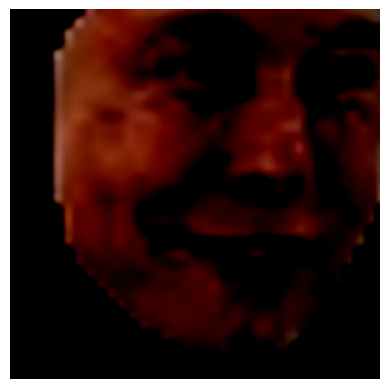

In [195]:
plt.imshow(temp_img)
plt.axis('off');

In [196]:
D_A.output_shape

(1, 16, 16)

In [197]:
temp_A.size()

torch.Size([1, 3, 256, 256])

In [198]:
temp_A.size(0) # batch_size

1

In [199]:
Tensor(np.ones((temp_A.size(0), *D_A.output_shape)))

tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1

In [200]:
Tensor(np.ones((temp_A.size(0), *D_A.output_shape))).shape

torch.Size([1, 1, 16, 16])

> Read More
- [The Effect of the Identity Mapping Loss on Monet's painting](https://www.researchgate.net/figure/The-effect-of-the-identity-mapping-loss-on-Monets-painting-photos-From-left-to-right_fig3_322060135)

So far we have looked at the cyclegan model, which does not require pairs. 

It is a very important model among various gan architectures, and will be the basis for stargan.


If you are satisfied with this cyclegan tutorial, I recommend that you continue learning the next [stargan tutorial](https://www.kaggle.com/songseungwon/stargan-tutorial-with-15-steps-make-fake-images)

Thank you!

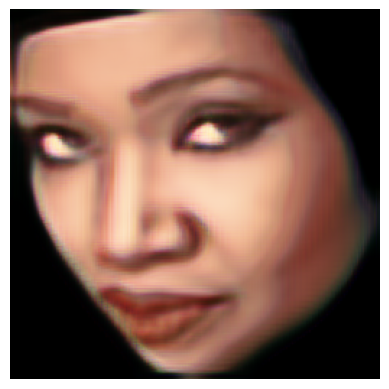

In [202]:
from PIL import Image
import numpy as np

# Load and preprocess the input image
input_image_path = "data1/RandomDataMasked/20240504063446489005.jpg"
input_image = Image.open(input_image_path)
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
input_tensor = preprocess(input_image).unsqueeze(0).cuda() if cuda else preprocess(input_image).unsqueeze(0)

# Pass the input image through the generator
G_AB.eval()
with torch.no_grad():
    generated_image = G_BA(input_tensor)

# Convert the generated image tensor to a numpy array
generated_image = generated_image.squeeze(0).cpu().detach().numpy()
generated_image = np.transpose(generated_image, (1, 2, 0))
generated_image = (generated_image + 1) / 2  # Denormalize the image data

# Visualize the generated image
plt.imshow(generated_image)
plt.axis('off')
plt.show()
